# Topic Modelling with Transformers

### Import libraries and set random seeds

In [4]:
import os
import random
import numpy as np
import torch
import torch.backends.cudnn

import pandas as pd
import matplotlib.pyplot as plt

import umap
import hdbscan
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance

from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample

import re

# Set environment variables early on
os.environ['PYTHONHASHSEED'] = '42'
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Global random seed for reproducibility
random_seed = 42

# Set Python built-in, NumPy, and Torch random seeds
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Ensure deterministic behavior in CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define a worker seed function for DataLoader
def seed_worker(worker_id):
    worker_seed = random_seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Create a torch Generator for DataLoader reproducibility
g = torch.Generator()
g.manual_seed(random_seed)

## Loading data

In [5]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/ekrltx48nq8ll7txpmkcg/singapore_airlines_reviews.csv?rlkey=lj0uqi5vpaaploqxg50yqbrj1&st=mindhem4&dl=1')

### Inspecting dataframe features 

In [6]:
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


In [7]:
pd.set_option('display.max_colwidth', 150)

In [8]:
# Step 1: Calculate the length of each review
df['review_length'] = df['text'].apply(len)

# For simplicity, let's consider "excellent" for positive and "terrible" for negative sentiments
df['contains_excellent'] = df['text'].str.contains('excellent', case=False).astype(int)
df['contains_terrible'] = df['text'].str.contains('terrible', case=False).astype(int)

In [9]:
df['published_date'] = pd.to_datetime(df['published_date'], format='ISO8601', utc=True)
df['year'] = df['published_date'].dt.year
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...,Ok,0,1352,0,0,2024
1,2024-03-11 23:39:13+00:00,Desktop,5,review,"The service on Singapore Airlines Suites Class was nothing but excellent. The cabin crew was warm and friendly and, most importantly, came across ...",The service in Suites Class makes one feel like VIP,0,4666,1,0,2024
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation for extra legroom seats 10 Dec. 4 Feb checked and seas were gone. They resold our paid for seats and ...",Don’t give them your money,0,420,0,0,2024
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, service are all brilliant. The crew are friendly and welcoming. We love flying with Singapore Airlines",Best Airline in the World,0,144,0,0,2024
4,2024-03-10 09:34:18+00:00,Desktop,2,review,"Premium Economy Seating on Singapore Airlines has narrow seats and poor leg room compared to Air NZ or Virgin. Drinks served in plastic beakers, ...",Premium Economy Seating on Singapore Airlines not worth the money!,0,582,0,0,2024


# Analysis Approach

### The data shows a sharp decline in customer ratings following a major event, likely the COVID-19 outbreak, which significantly impacted the airline industry. To explore this trend further, I will identify topics within reviews from the past 7 years and compare their development on an annual basis. For concrete analysis and actionable recommendations, my focus will be on the years not directly influenced by COVID-19 (2018, 2019, 2023, and 2024).


In [10]:
# Capture the month, might be used later
df['month'] = df['published_date'].dt.month
df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,review_length,contains_excellent,contains_terrible,year,month
0,2024-03-12 18:41:14+00:00,Desktop,3,review,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...,Ok,0,1352,0,0,2024,3
1,2024-03-11 23:39:13+00:00,Desktop,5,review,"The service on Singapore Airlines Suites Class was nothing but excellent. The cabin crew was warm and friendly and, most importantly, came across ...",The service in Suites Class makes one feel like VIP,0,4666,1,0,2024,3
2,2024-03-11 16:20:23+00:00,Desktop,1,review,"Booked, paid and received email confirmation for extra legroom seats 10 Dec. 4 Feb checked and seas were gone. They resold our paid for seats and ...",Don’t give them your money,0,420,0,0,2024,3
3,2024-03-11 11:12:27+00:00,Desktop,5,review,"Best airline in the world, seats, food, service are all brilliant. The crew are friendly and welcoming. We love flying with Singapore Airlines",Best Airline in the World,0,144,0,0,2024,3
4,2024-03-10 09:34:18+00:00,Desktop,2,review,"Premium Economy Seating on Singapore Airlines has narrow seats and poor leg room compared to Air NZ or Virgin. Drinks served in plastic beakers, ...",Premium Economy Seating on Singapore Airlines not worth the money!,0,582,0,0,2024,3


In [11]:
# Defining time periods for comparative analysis
# Pre-pandemic period: 2018-2019 (before COVID-19 impact)
# Post-pandemic period: 2023-2024 (recovery phase)

# Creating separate dataframes for each time period
pre_pandemic_df = df[(df['year'] == 2018) | (df['year'] == 2019)]
post_pandemic_df = df[(df['year'] == 2023) | (df['year'] == 2024)]

# Verifying data distribution across periods
print(f"Pre-pandemic data shape: {pre_pandemic_df.shape}")
print(f"Post-pandemic data shape: {post_pandemic_df.shape}")
print(f"Total records in analysis: {pre_pandemic_df.shape[0] + post_pandemic_df.shape[0]}, Original dataset size: {df.shape[0]}")


Pre-pandemic data shape: (7821, 12)
Post-pandemic data shape: (631, 12)
Total records in analysis: 8452, Original dataset size: 10000


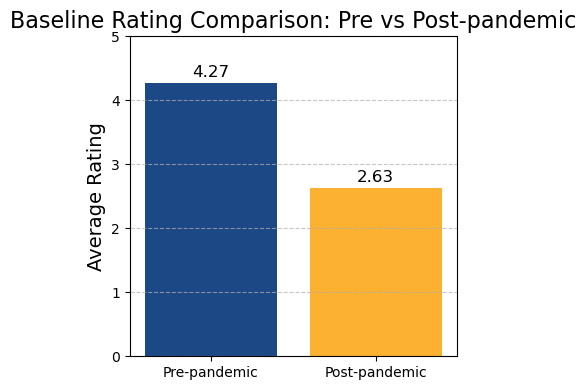

Pre-pandemic average rating (baseline): 4.27
Post-pandemic average rating (baseline): 2.63
Baseline difference: 0.38 (will compare with sentiment changes)


In [12]:
# Calculate average ratings for pre-pandemic and post-pandemic periods as baseline metrics
# This serves as a foundation for comparing changes in customer satisfaction over time
pre_pandemic_avg_rating = pre_pandemic_df['rating'].mean()
post_pandemic_avg_rating = post_pandemic_df['rating'].mean()

# Create a DataFrame for plotting the baseline comparison
avg_ratings_df = pd.DataFrame({
    'Period': ['Pre-pandemic', 'Post-pandemic'],
    'Average Rating': [pre_pandemic_avg_rating, post_pandemic_avg_rating]
})

# Create the bar plot to visualize the baseline rating difference
plt.figure(figsize=(4, 4))
bars = plt.bar(avg_ratings_df['Period'], avg_ratings_df['Average Rating'], color=['#1D4886', '#FCB130'])
plt.title('Baseline Rating Comparison: Pre vs Post-pandemic', fontsize=16)
plt.ylabel('Average Rating', fontsize=14)
plt.ylim(0, 5)  # Set y-axis limit to match the rating scale (1-5)

# Add the actual values on top of the bars for clear reference
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', fontsize=12)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Output baseline metrics for reference in subsequent sentiment and topic analyses
print(f"Pre-pandemic average rating (baseline): {pre_pandemic_avg_rating:.2f}")
print(f"Post-pandemic average rating (baseline): {post_pandemic_avg_rating:.2f}")
print(f"Baseline difference: {(pre_pandemic_avg_rating - post_pandemic_avg_rating)/pre_pandemic_avg_rating:.2f} (will compare with sentiment changes)")


Ratings fell by 38% from 2018/2019 to 2023/2024


### Embedding Model Choice and Fine-Tuning Strategy

I chose to fine-tune the embedding model in a separate file to ensure reproducibility. Directly training an embedding model solely on airline-specific reviews is challenging due to the random weight assignments inherent in the imported functions, which makes achieving consistent results very difficult.

Instead, I leveraged the pretrained **paraphrase-distilroberta-base-v2** model. This model offers several advantages for identifying topics within airline review data:

- **Robust Sentence-Level Representations:**  
  It is specifically designed to capture the semantic similarity between sentences. This quality is crucial when dealing with the nuances of airline reviews, as it enables the grouping of similar experiences even when the phrasing differs.

- **Pretrained on Diverse Data:**  
  The model has been trained on a wide-ranging corpus, allowing it to understand various linguistic patterns. This broad training helps it adapt effectively to the domain-specific language found in airline reviews, providing a solid starting point for further fine-tuning.

- **Efficiency and Consistency:**  
  By beginning with a high-quality, pretrained model, the fine-tuning process becomes more efficient. This approach minimizes the impact of randomness inherent in full-scale training, leading to more reproducible and stable topic modeling results.

Overall, this strategy not only enhances reproducibility but also leverages the robust capabilities of an established pretrained model, which I fine-tuned on carefully selected example sentences, making it well-suited for extracting meaningful topics from airline review data.


In [13]:
# Load the previously trained embedding model
model_path = "trained_embedding_model"
embedding_model = SentenceTransformer(model_path)

### UMAP Model Configuration and Rationale
The UMAP model is configured with the following parameters:

- **n_neighbor**s**=20:
Setting it to 20 strikes a balance between capturing local detail and preserving the overall global structure.

- **n_components**=5:
Reducing the embedding dimensionality to 5 components provides a more compact representation.

- **min_dist**=0.1:
A value of 0.1 ensures moderate separation among clusters, which helps maintain a clear distinction between similar topics and prevents the clusters from being too tightly packed.

- **metric**='cosine':
Using 'cosine' as the distance metric is particularly suitable for text embeddings.

- **random_state**=42:
Specifying a fixed random seed (42) ensures that the UMAP transformation is reproducible. 

Overall, this UMAP configuration is tailored to generate a meaningful, low-dimensional representation of the airline review embeddings, balancing detail and efficiency while ensuring reproducibility in the analysis.

In [14]:
# UMAP for dimensionality reduction with parameters for better topic separation
umap_model = umap.UMAP(n_neighbors=20, n_components=5, min_dist=0.1, metric='cosine', random_state=42)

### HDBSCAN Clustering Configuration and Rationale

This HDBSCAN configuration is designed to produce more granular and reliable topic clusters from airline review data. The rationale behind each parameter choice is as follows:

- **min_cluster_size = 20:**  
  Set to capture smaller, more specific clusters that reveal subtle topics.

- **min_samples = 4:**  
  Allows for the formation of meaningful clusters even when they have fewer supporting points.

- **metric = 'euclidean':**  
  Chosen to work effectively with the normalized embedding space.

- **cluster_selection_method = 'leaf':**  
  Enables extraction of the most detailed clusters from the hierarchy.

- **prediction_data = True:**  
  Supports assigning new data points to clusters consistently.

- **alpha = 1.2:**  
  Adjusts the clustering sensitivity to account for varying density in the dataset.

- **core_dist_n_jobs = 1:**  
  Ensures reproducibility by eliminating nondeterministic parallel processing.

Overall, these settings aim to fine-tune the clustering process to capture nuanced topics while maintaining consistency and reproducibility in the analysis.


In [15]:
# HDBSCAN for clustering with parameters to create more granular topics
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20,  # Smaller size captures more specific topic clusters
                                min_samples=4,        # Lower threshold enables formation of meaningful smaller clusters
                                metric='euclidean',
                                cluster_selection_method='leaf',  # Extracts detailed clusters from hierarchy
                                prediction_data=True,
                                alpha=1.2,
                                core_dist_n_jobs=1)   # Single job ensures reproducibility

### Stopwords Configuration and CountVectorizer Setup

Before vectorizing the text, I download and combine stopwords to filter out uninformative words. The rationale behind this process is as follows:

- **Downloading NLTK Stopwords:**  
  Ensures that the standard English stopword list is available.

- **Combining Stopwords:**  
  Merges the default English stopwords with additional airline-specific terms (e.g., 'flight', 'airline', 'sia', etc.). This removes frequently occurring domain-specific words that offer little value for topic differentiation, reducing noise and improving topic quality.

- **Removing Duplicates:**  
  Converting the combined list into a set eliminates duplicates, resulting in a clean, efficient stopword list.

- **CountVectorizer Parameters:**
  - **stop_words:**  
    Uses the customized list to filter out both generic and domain-specific common words.
    
  - **ngram_range=(1, 3):**  
    Captures unigrams, bigrams, and trigrams to recognize informative phrases that provide contextual nuance for topic modeling.
    
  - **min_df=0.1:**  
    Excludes words that appear in less than 10% of the documents, minimizing the impact of rare, less informative terms.
    
  - **max_df=0.80:**  
    Filters out words that occur in more than 80% of the documents, preventing overly common terms from skewing the analysis.

This configuration focuses on retaining the most informative and context-rich words for extracting distinct topics from the airline review data.


In [16]:
# Download stopwords
nltk.download('stopwords', quiet=True)

# Combine English stopwords with airline-specific stopwords
english_stopwords = set(stopwords.words('english'))
airline_stop_words = list(english_stopwords) + [
    'flight', 'airline', 'airlines', 'singapore', 'sq', 
    'sia', 'singapore airlines', 'fly', 'flying', 'flew', 'flown',
    'very', 'really', 'just', 'also', 'sa', 'recommend', 'trouble', 
    ' highly recommend', 'recommended', 'avoid', 'nothing', 'disappointing', 
    'disappointed', 'terrible', 'awful', 'horrible', 'excellent', 'amazing', 
    'outstanding', 'poor', 'worst', 'best', 'unprofessional', 'inconvenient', 
    'hassle', 'nightmare', 'unacceptable', 'mediocre', 'subpar', 'wonderful', 
    'fantastic'
]
# Remove duplicates
airline_stop_words = list(set(airline_stop_words))

vectorizer_model = CountVectorizer(
    stop_words=airline_stop_words, 
    ngram_range=(1, 3),  # Include up to trigrams to capture phrases
    min_df=0.1,          # Minimum document frequency
    max_df=0.80          # Maximum document frequency percentage
)


### Maximal Marginal Relevance (MMR) Configuration for Topic Representation

The MMR model is configured with the following parameters:

- **diversity = 0.5:**  
  This value establishes a balanced trade-off between keyword relevance and diversity. A diversity setting of 0.5 ensures that the selected keywords for each topic capture different aspects, reducing redundancy while maintaining core relevance.

- **top_n_words = 20:**  
  This parameter specifies that up to 20 words are chosen to represent each topic. It provides a detailed yet concise summary of the topic's essential characteristics.

#### Rationale for Choosing MMR over Other Representation Methods

- **Balanced Representation:**  
  Unlike simpler ranking methods that might select redundant keywords, MMR actively promotes diversity among the top words. This results in topic representations that cover various facets of the underlying theme.

- **Enhanced Clarity:**  
  By reducing redundancy, MMR produces more informative and distinct topic summaries. This is particularly important for complex datasets like airline reviews, where overlapping vocabulary can obscure meaningful distinctions.

- **Tunable Parameters:**  
  The adjustability of the diversity parameter allows for fine-tuning based on the dataset's characteristics, offering more control compared to conventional methods that do not explicitly optimize for diversity.

Overall, MMR is chosen because it delivers topic representations that are both rich in content and varied, making it especially suitable for capturing the nuanced themes present in airline review data.


In [17]:
# Configure MMR for topic representation with diversity parameter
mmr_model = MaximalMarginalRelevance(
    diversity=0.5, top_n_words=20,  
)

### BERTopic Model Configuration and Execution Rationale

To ensure reproducibility, the random seeds are first set using:

- **random.seed(42) and np.random.seed(42):**  
  These calls ensure that all random operations are deterministic, which is crucial for obtaining consistent results in the topic modeling process.

Additional settings in the BERTopic configuration include:

- **calculate_probabilities=True:**  
  Enables the computation of topic probabilities, allowing for a probabilistic interpretation of topic assignments.

- **min_topic_size=15:**  
  Setting a higher minimum topic size ensures that the topics are broader and more representative, filtering out overly granular or insignificant clusters.

After fitting the model on the entire dataset, further refinement is achieved by reducing the number of topics to 20. This topic reduction process merges similar topics, resulting in a more coherent and manageable final set of topics, while the final topics and their probabilities are then extracted for analysis.


In [18]:
# Setting random seeds for reproducibility
random.seed(42)
np.random.seed(42)

topic_model_all_data = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=mmr_model,              
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=15          
)

# Fitting the model to the entire dataset
topics_all_data, probs_all_data = topic_model_all_data.fit_transform(df['text'])

# Reducing to a more manageable number of topics
topic_model_all_data = topic_model_all_data.reduce_topics(df['text'], nr_topics=20)

# Extracting the final topics and their probabilities
topics_all_data = topic_model_all_data.topics_
probs_all_data = topic_model_all_data.probabilities_

2025-04-14 11:56:32,208 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-04-14 11:57:30,029 - BERTopic - Embedding - Completed ✓
2025-04-14 11:57:30,029 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-14 11:57:46,076 - BERTopic - Dimensionality - Completed ✓
2025-04-14 11:57:46,076 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-14 11:57:46,686 - BERTopic - Cluster - Completed ✓
2025-04-14 11:57:46,690 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 11:57:53,241 - BERTopic - Representation - Completed ✓
2025-04-14 11:57:53,507 - BERTopic - Topic reduction - Reducing number of topics
2025-04-14 11:57:53,515 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 11:57:55,912 - BERTopic - Representation - Completed ✓
2025-04-14 11:57:55,915 - BERTopic - Topic reduction - Reduced number of topics from 55 to 20


In [19]:
topic_model_all_data.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,6762,-1_took_booked_asked_people,"[took, booked, asked, people, another, water, world, old, changi, small, bed, felt, pleasant, wife, london, a380, arrived, minutes, travelling, cu...","[Both of me and my wife decided to have a flight experience, with Singapore Airlines, in their longest route (SIN - EWR) during 3rd week of May - ..."
1,0,634,0_sydney_australia_perth_wife,"[sydney, australia, perth, wife, enjoyed, melbourne, london, thank, arrived, silk air, home, smooth, plenty, ms, gave, travelling, went, great ser...","[Was scheduled to fly on 5 Aug 1640hrs on SQ919 back to Singapore from Manila, and had earlier pre-booked the chef and ordered a steak dinner for ..."
2,1,394,1_pleasant_plenty_highly_smooth,"[pleasant, plenty, highly, smooth, staff friendly, good service, landing, lovely, tasty, films, service great, good entertainment, facilities, del...",[A wonderful flight. Have taken many budget airlines for work recently and was nice to get back into 'normal' economy. \nWent very smoothly from b...
3,2,385,2_refund_told_booking_customer service,"[refund, told, booking, customer service, cancelled, tickets, agent, email, day, received, paid, weeks, another, cancel, lost, later, number, give...",[Singapore airlines says call centre bookings will cost $50. Do not use their website. Rather pay the 50$ than use the website. Their online boo...
4,3,344,3_love_planes_world_staff always,"[love, planes, world, staff always, smile, great service, enjoy, travelling, know, friendly helpful, problem, courteous, asia, many times, staff f...",[I am a frequent traveller and had taken many flights with different airlines for my business and leisure trips. I must give compliments to SIA fo...
5,4,205,4_sin_world_qf_crews,"[sin, world, qf, crews, standards, good service, carriers, love, thank, forward, family, cx, perfect, recently, worth, must, dps, doubt, safety, 2...",[I would like to share my feedback on my recent & first trip With SQ. and why i choose to fly with SQ\n\nAs per business need in my current organ...
6,5,187,5_highly_airplane_good service_great food,"[highly, airplane, good service, great food, service always, staffs, superb, service smile, perfect, company, value money, love, comfortable seats...","[They know how to look after people’s needs on a long journey. Offering meals, snacks and drinks with a smile and always positive. They always loo..."
7,6,163,6_breakfast_eat_worse_found,"[breakfast, eat, worse, found, gone, menu, water, bread, told, dinner, booking, qantas, tried, chicken, rice, airways, small, seems, changi, inedi...",[Before reading this review please note that this was not my 1st time flying Singapore airlines and every other time was a pleasure.\nThat being s...
8,7,153,7_deck_380_airbus_upper,"[deck, 380, airbus, upper, old, 777, airbus 380, flat bed, configuration, new a380, plenty, lie, airbus a380, suites, quiet, large, a380 great, sc...",[My first trip on A380 was perfect. Got upper deck seats. Upper deck is quieter as compared to lower deck(travelled in Lower deck on return). You ...
9,8,137,8_bed_777_uncomfortable_a380,"[bed, 777, uncomfortable, a380, screen, old, feet, recline, boeing, sin, airbus, hard, storage, configuration, b787, lie, flat bed, size, boeing 7...",[ICN to MEL via SIN on Singapore Airlines business class. \n\nThe first leg from ICN to SIN was on A330-300. Although the aircraft was only about ...


In [20]:
# Print the "Name" column from the topic_model_all_data.get_topic_info() DataFrame
topic_info = topic_model_all_data.get_topic_info()
print("\nTopic Names:")
for name in topic_info['Name']:
    print(name)

# Print the representation of each topic
print("\nRepresentation:")
for topic_id in topic_model_all_data.get_topics():
    if topic_id != -1:  # Skip the outlier topic
        print(f"Topic {topic_id}: {topic_model_all_data.get_topic(topic_id)}")



Topic Names:
-1_took_booked_asked_people
0_sydney_australia_perth_wife
1_pleasant_plenty_highly_smooth
2_refund_told_booking_customer service
3_love_planes_world_staff always
4_sin_world_qf_crews
5_highly_airplane_good service_great food
6_breakfast_eat_worse_found
7_deck_380_airbus_upper
8_bed_777_uncomfortable_a380
9_water_chicken_dinner_rice
10_difference_worth_pe_cost
11_refund_customer service_phone_email
12_priority_extra leg room_worth extra_premium economy seats
13_smooth_needs_fss_compared
14_changi_transit changi_transit changi airport_jewel
15_900_airbus_brand new_350
16_plenty_friendly staff_selection comfortable_comfortable bed
17_dubai_a380_prefer emirates_year emirates
18_japanese_narita_osaka_numbered

Representation:
Topic 0: [('sydney', 0.013735485913974539), ('australia', 0.009201513027538764), ('perth', 0.009181914821733651), ('wife', 0.009065417714071803), ('enjoyed', 0.008656909620775541), ('melbourne', 0.008522318682690735), ('london', 0.008388678328754628), ('t

In [21]:
fig_pre = topic_model_all_data.visualize_topics()
fig_pre.show()

Most topics are overlapping due to reduced_topics. They still account for different keywords. Dimensionality reduction plays a role in this representation as well.

In [22]:
topic_model_all_data.visualize_barchart(top_n_topics=len(topic_model_all_data.get_topic_info()))

In [23]:
topic_model_all_data.visualize_term_rank()

Overall, the term scores are low, but the first term in most topics is notably dominant. This indicates that the leading keyword has a strong influence, representing the majority of the documents within that topic.


In [24]:
# Get topic representations
topic_info = topic_model_all_data.get_topic_info()
topic_representations = {topic: topic_model_all_data.get_topic(topic) for topic in topic_info['Topic'].unique() if topic != -1}
topic_representations[-1] = [("No specific topic", 1.0)]  # Add representation for outlier topic

# Create a mapping of topic IDs to their names
topic_names = {row['Topic']: row['Name'] for _, row in topic_info.iterrows()}

# Create the DataFrame with topic information
topic_df_covid = pd.DataFrame({
    "topic": topics_all_data, 
    "document": df['text'], 
    "year": df['year'], 
    "month": df['month'],
    "topic_name": [topic_names[topic] for topic in topics_all_data],
    "topic_keywords": [topic_representations[topic][:7] for topic in topics_all_data]  # Top 7 keywords per topic
})

In [25]:
topic_df_covid.head()

,topic,document,year,month,topic_name,topic_keywords
0,-1,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...,2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]"
1,-1,"The service on Singapore Airlines Suites Class was nothing but excellent. The cabin crew was warm and friendly and, most importantly, came across ...",2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]"
2,-1,"Booked, paid and received email confirmation for extra legroom seats 10 Dec. 4 Feb checked and seas were gone. They resold our paid for seats and ...",2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]"
3,3,"Best airline in the world, seats, food, service are all brilliant. The crew are friendly and welcoming. We love flying with Singapore Airlines",2024,3,3_love_planes_world_staff always,"[(love, 0.00994687351624584), (planes, 0.009345561622330285), (world, 0.009305233484127673), (staff always, 0.008951248231941326), (smile, 0.00796..."
4,10,"Premium Economy Seating on Singapore Airlines has narrow seats and poor leg room compared to Air NZ or Virgin. Drinks served in plastic beakers, ...",2024,3,10_difference_worth_pe_cost,"[(difference, 0.014225606438173386), (worth, 0.013390597137677443), (pe, 0.012140364546756344), (cost, 0.011699969839689022), (qantas, 0.010875788..."


### Sentiment Score for Each Document

Including a sentiment score for each document enables me to later verify whether the ratings are in line with the sentiment expressed in the review. Reviews can be subjective, so a low rating might not always be accompanied by overt negative comments about the airline or its related topics.


In [26]:
# Download VADER lexicon
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Add airline-specific terms to the VADER lexicon to improve accuracy
# These are terms commonly found in airline reviews with sentiment connotations
airline_specific_terms = {
    'delay': -2.0,
    'cancelled': -3.0,
    'comfortable': 2.0,
    'spacious': 2.0,
    'not spacious': -2.0,
    'cramped': -2.0,
    'attentive': 3.0,
    'rude': -3.0,
    'refund': -1.0,
    'legroom': 1.5,
    'entertainment': 1.0,
    # Additional airline-specific sentiment terms
    'frustration': -2.5,
    'disappointing': -2.0,
    'disappointed': -2.0,
    'terrible': -3.0,
    'awful': -3.0,
    'horrible': -3.0,
    'excellent': 3.0,
    'amazing': 3.0,
    'outstanding': 3.0,
    'poor': -2.0,
    'worst': -3.5,
    'best': 3.5,
    'unprofessional': -2.5,
    'inconvenient': -2.0,
    'hassle': -2.0,
    'nightmare': -3.0,
    'unacceptable': -2.5,
    'mediocre': -1.5,
    'subpar': -2.0,
    'wonderful': 3.0,
    'fantastic': 3.0
}

# Update the VADER lexicon with airline-specific terms
for term, score in airline_specific_terms.items():
    sid.lexicon[term] = score

# Function to classify sentiment based on both compound score and rating
def get_airline_sentiment(text, rating=None):
    if not isinstance(text, str):
        return 'neutral'  # Handle non-string inputs
    
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    # Adjust thresholds for airline reviews which tend to be more polarized
    if compound_score >= 0.1:
        return 'positive'
    elif compound_score <= -0.1:
        return 'negative'
    else:
        # If we have the rating, use it as a tiebreaker for neutral sentiment
        if rating is not None:
            if rating >= 4:
                return 'positive'
            elif rating <= 2:
                return 'negative'
        return 'neutral'

# Apply sentiment analysis to each review
topic_df_covid['sentiment_score'] = topic_df_covid['document'].apply(
    lambda x: sid.polarity_scores(x)['compound'] if isinstance(x, str) else 0
)



topic_df_covid['sentiment'] = topic_df_covid['document'].apply(get_airline_sentiment)    

# Display the first few rows with sentiment information
print("Singapore Airlines Reviews with Sentiment Analysis:")
print(topic_df_covid[['topic', 'topic_name', 'sentiment', 'sentiment_score']].head())

# Count of reviews by sentiment
sentiment_counts = topic_df_covid['sentiment'].value_counts()
print("\nSentiment distribution in Singapore Airlines reviews:")
print(sentiment_counts)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mariuskiefer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Singapore Airlines Reviews with Sentiment Analysis:
   topic                        topic_name sentiment  sentiment_score
0     -1       -1_took_booked_asked_people  positive           0.9870
1     -1       -1_took_booked_asked_people  positive           0.9941
2     -1       -1_took_booked_asked_people  positive           0.6705
3      3  3_love_planes_world_staff always  positive           0.9618
4     10       10_difference_worth_pe_cost  negative          -0.6900

Sentiment distribution in Singapore Airlines reviews:
sentiment
positive    8019
negative    1777
neutral      204
Name: count, dtype: int64


In [27]:
# Append rating from df to topic_df_covid
if 'rating' in df.columns:
    # Create a mapping from document to rating
    doc_to_rating = dict(zip(df['text'], df['rating']))
    
    # Add rating column to topic_df_covid
    topic_df_covid['rating'] = topic_df_covid['document'].map(doc_to_rating)
    
    print("\nReviews with sentiment and rating:")
    print(topic_df_covid[['topic', 'topic_name', 'sentiment', 'sentiment_score', 'rating']].head())
else:
    print("\nRating information is not available in the dataframe.")




Reviews with sentiment and rating:
   topic                        topic_name sentiment  sentiment_score  rating
0     -1       -1_took_booked_asked_people  positive           0.9870       3
1     -1       -1_took_booked_asked_people  positive           0.9941       5
2     -1       -1_took_booked_asked_people  positive           0.6705       1
3      3  3_love_planes_world_staff always  positive           0.9618       5
4     10       10_difference_worth_pe_cost  negative          -0.6900       2


In [28]:
topic_df_covid.head()

,topic,document,year,month,topic_name,topic_keywords,sentiment_score,sentiment,rating
0,-1,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...,2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]",0.9870,positive,3
1,-1,"The service on Singapore Airlines Suites Class was nothing but excellent. The cabin crew was warm and friendly and, most importantly, came across ...",2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]",0.9941,positive,5
2,-1,"Booked, paid and received email confirmation for extra legroom seats 10 Dec. 4 Feb checked and seas were gone. They resold our paid for seats and ...",2024,3,-1_took_booked_asked_people,"[(No specific topic, 1.0)]",0.6705,positive,1
3,3,"Best airline in the world, seats, food, service are all brilliant. The crew are friendly and welcoming. We love flying with Singapore Airlines",2024,3,3_love_planes_world_staff always,"[(love, 0.00994687351624584), (planes, 0.009345561622330285), (world, 0.009305233484127673), (staff always, 0.008951248231941326), (smile, 0.00796...",0.9618,positive,5
4,10,"Premium Economy Seating on Singapore Airlines has narrow seats and poor leg room compared to Air NZ or Virgin. Drinks served in plastic beakers, ...",2024,3,10_difference_worth_pe_cost,"[(difference, 0.014225606438173386), (worth, 0.013390597137677443), (pe, 0.012140364546756344), (cost, 0.011699969839689022), (qantas, 0.010875788...",-0.6900,negative,2


Comparing the ratings, sentiment scores, and review text in Observation 0 suggests that the sentiment scores may not always accurately reflect the underlying sentiment. Therefore, it is useful to compare ratings and sentiment scores, both individually adding value to the analysis. A sentiment score of almost 1 (sclaed to almost 5/5) does not reflect a rating of 3.


### Evolution of Sentiment and Ratings Over Time

This visualization captures the development of sentiment and ratings for the selected topics over the years.


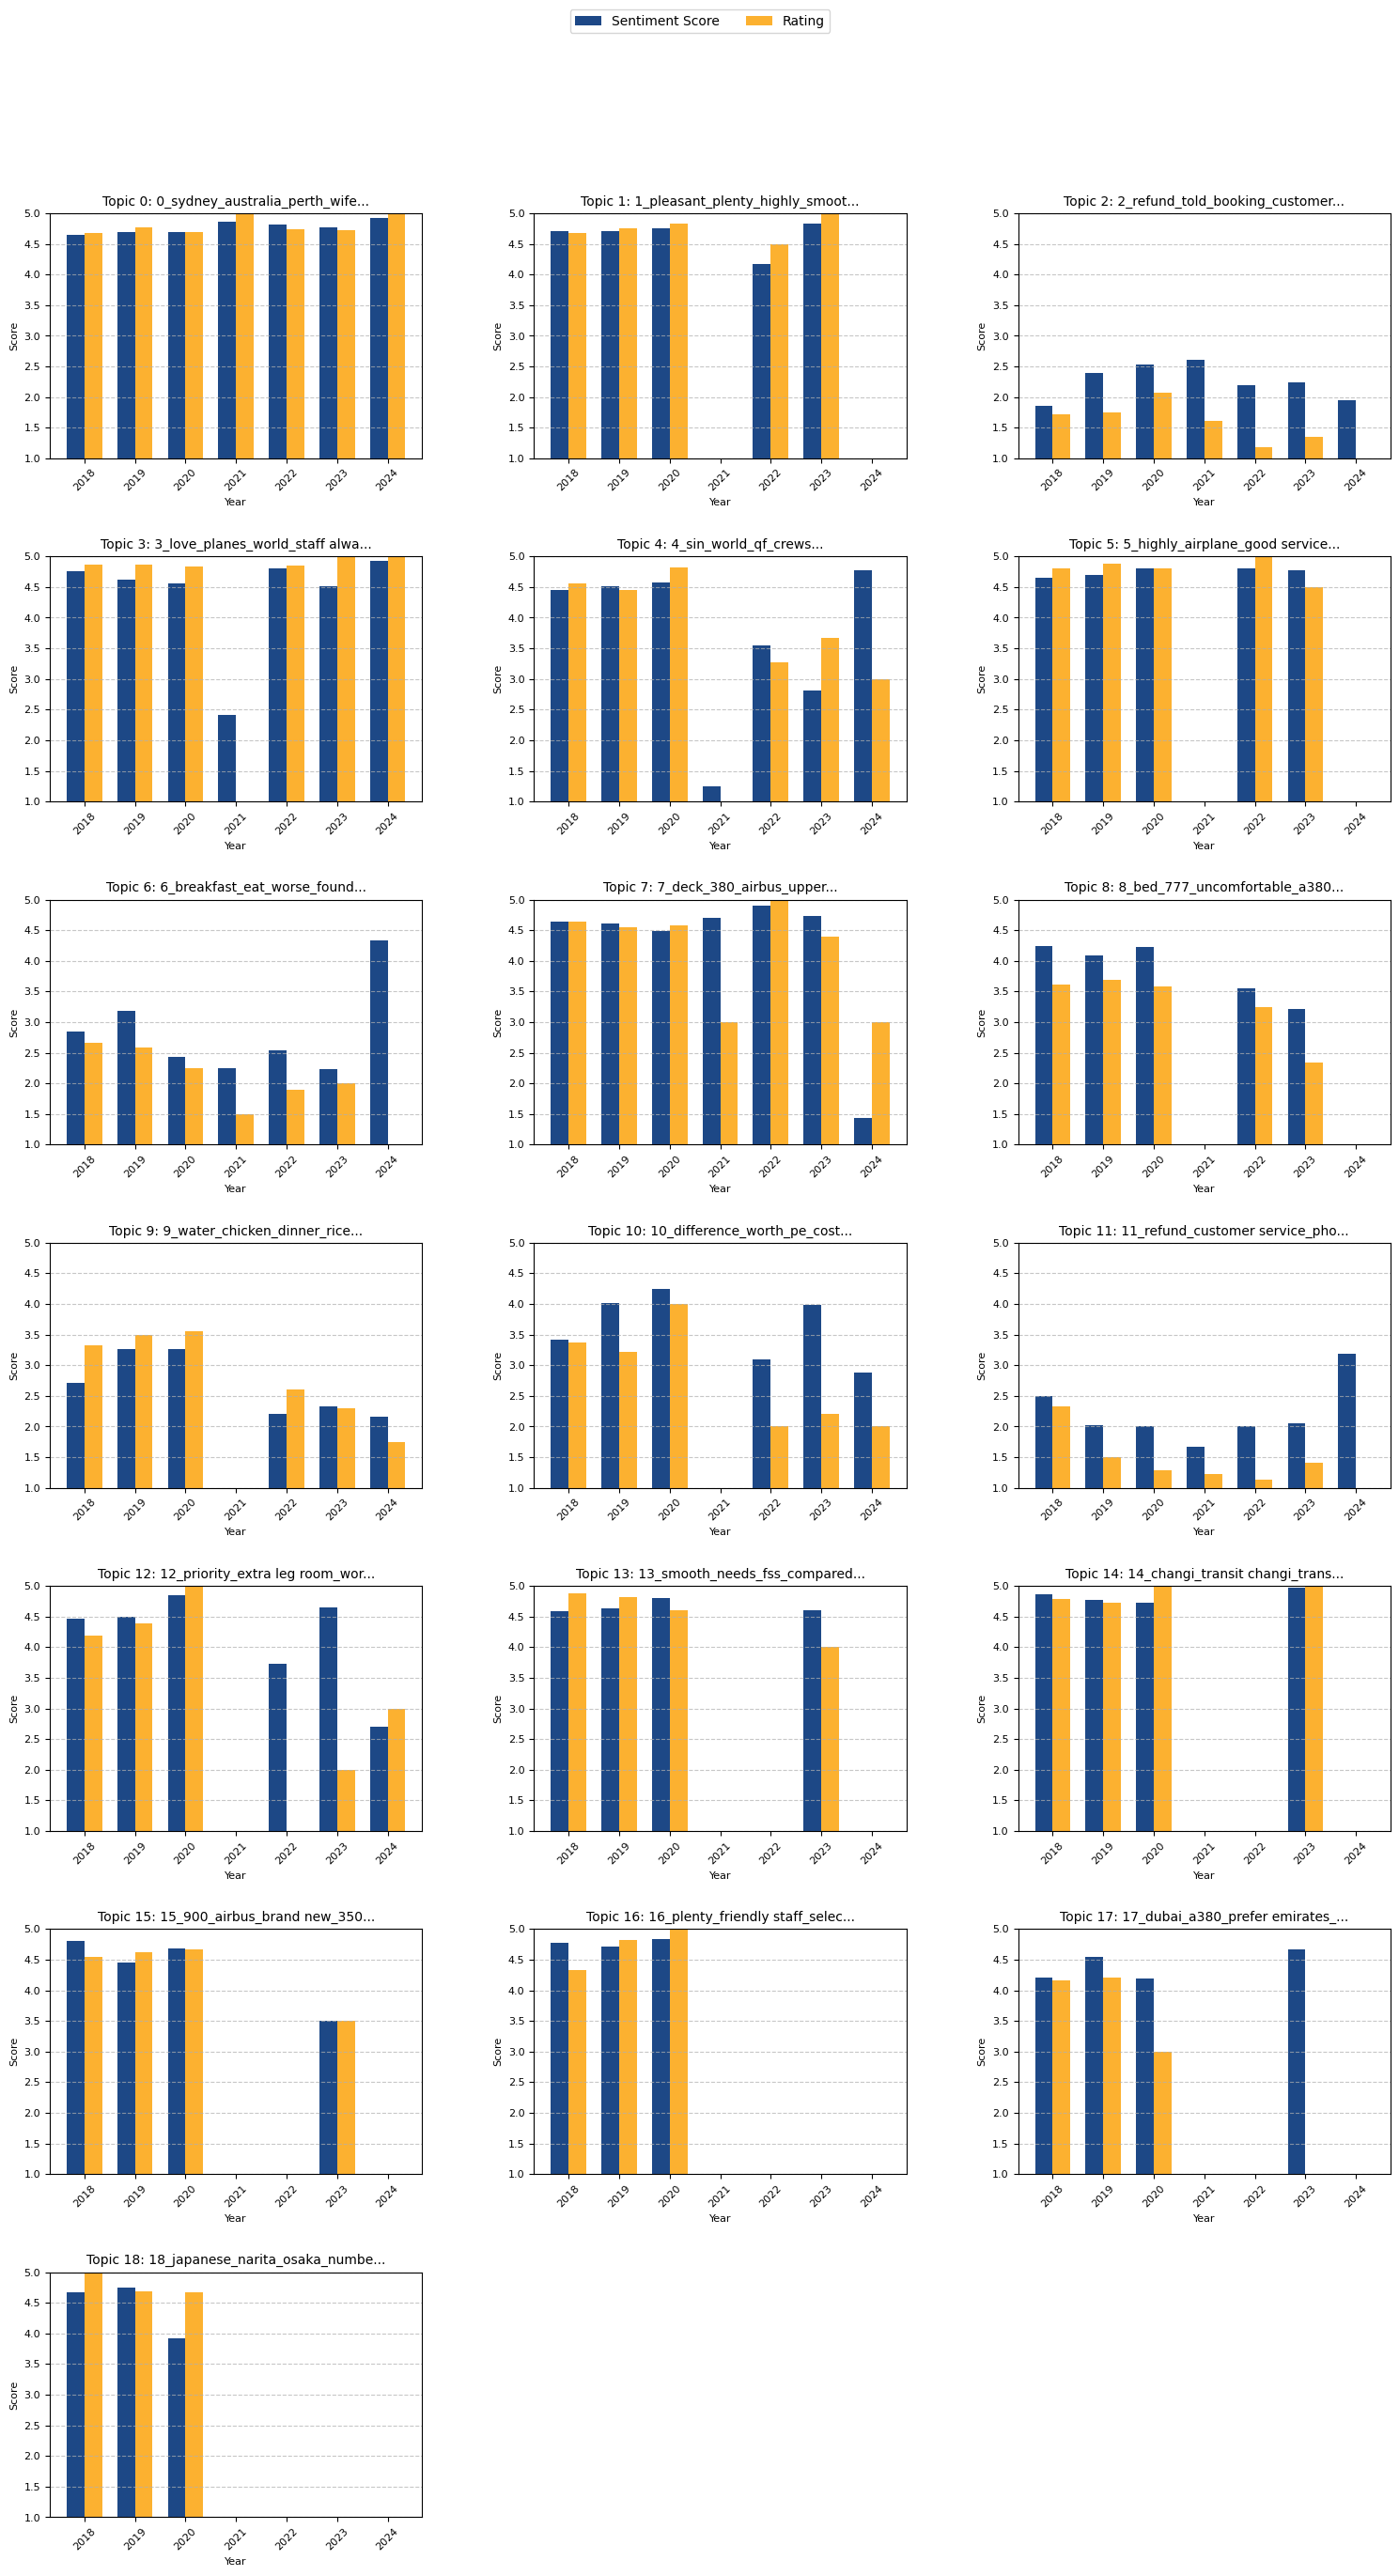


Summary of Mean Sentiment Score and Rating by Topic and Year:
     topic  year  scaled_sentiment_score    rating  \
7        0  2018                4.641266  4.682927   
8        0  2019                4.690891  4.776836   
9        0  2020                4.691325  4.686567   
10       0  2021                4.867400  5.000000   
11       0  2022                4.822470  4.739130   
..     ...   ...                     ...       ...   
106     17  2020                4.194400  3.000000   
107     17  2023                4.664400  1.000000   
108     18  2018                4.677000  5.000000   
109     18  2019                4.741969  4.692308   
110     18  2020                3.915733  4.666667   

                                      topic_name  
7                  0_sydney_australia_perth_wife  
8                  0_sydney_australia_perth_wife  
9                  0_sydney_australia_perth_wife  
10                 0_sydney_australia_perth_wife  
11                 0_sydney_austr

In [29]:
# Extract year from the original dataframe
if 'year' in df.columns and 'text' in df.columns:
    # Create a mapping from document to year
    doc_to_year = dict(zip(df['text'], df['year']))
    
    # Add year column to topic_df_covid
    topic_df_covid['year'] = topic_df_covid['document'].map(doc_to_year)
    
    # Scale sentiment score from [-1,1] to [1,5] to match rating scale
    topic_df_covid['scaled_sentiment_score'] = topic_df_covid['sentiment_score'].apply(
        lambda x: ((x + 1) / 2) * 4 + 1
    )
    
    # Group by topic and year to calculate mean sentiment score and rating
    topic_year_sentiment = topic_df_covid.groupby(['topic', 'year']).agg({
        'scaled_sentiment_score': 'mean',
        'rating': 'mean'
    }).reset_index()
    
    # Filter out the -1 topic (no specific topic)
    topic_year_sentiment_filtered = topic_year_sentiment[topic_year_sentiment['topic'] != -1]
    
    # Create a mapping from topic ID to topic name
    topic_name_map = dict(zip(topic_df_covid['topic'], topic_df_covid['topic_name']))
    
    # Add topic name to the aggregated dataframe
    topic_year_sentiment_filtered['topic_name'] = topic_year_sentiment_filtered['topic'].map(topic_name_map)
    
    # Get unique topics and years
    unique_topics = topic_year_sentiment_filtered['topic'].unique()
    years = sorted(topic_year_sentiment_filtered['year'].unique())
    
    # Create a more compact grid layout
    n_topics = len(unique_topics)
    n_cols = 3  # Number of columns in the grid
    n_rows = (n_topics + n_cols - 1) // n_cols  # Calculate number of rows needed
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), squeeze=False)
    
    # Flatten the axes array for easier indexing
    axes_flat = axes.flatten()
    
    for i, topic in enumerate(unique_topics):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Filter data for this topic
            topic_data = topic_year_sentiment_filtered[topic_year_sentiment_filtered['topic'] == topic]
            topic_name = topic_data['topic_name'].iloc[0]
            
            # Create a DataFrame with all years (to handle missing years)
            all_years_df = pd.DataFrame({'year': years})
            topic_data = pd.merge(all_years_df, topic_data, on='year', how='left').fillna(0)
            topic_data = topic_data.sort_values('year')
            
            # Get x positions for bars
            x_pos = np.arange(len(years))
            bar_width = 0.35
            
            # Define colors for bars
            sentiment_color = '#1D4886'  # Blue
            rating_color = '#FCB130'     # Orange
            
            # Plot bars
            ax.bar(x_pos - bar_width/2, topic_data['scaled_sentiment_score'], bar_width, 
                   color=sentiment_color, label='Sentiment Score')
            ax.bar(x_pos + bar_width/2, topic_data['rating'], bar_width, 
                   color=rating_color, label='Rating')
            
            # Set title and labels
            ax.set_title(f'Topic {topic}: {topic_name[:30]}...', fontsize=10)
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel('Score', fontsize=8)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(years, rotation=45, fontsize=8)
            ax.set_ylim(1, 5)  # Set y-axis limits
            ax.tick_params(axis='y', labelsize=8)
            ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Hide any unused subplots
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
    plt.show()
    
    # Print summary statistics
    print("\nSummary of Mean Sentiment Score and Rating by Topic and Year:")
    print(topic_year_sentiment_filtered.sort_values(['topic', 'year']))
else:
    print("\nYear or text information is not available in the dataframe.")


The plots indicate that COVID introduced significant uncertainty and noise into the reviews. This visualization clearly shows how topics evolved before, during, and after the pandemic.


### Comparing Topic Performance Pre- and Post-COVID

To better assess how certain topics have continued to underperform relative to pre-COVID times, I compared data from the 2018–2019 period with that from 2023–2024.



Percentage Changes in Mean Rating and Sentiment Score Between 2018-2019 and 2023-2024:


,topic,topic_name,rating_period1,rating_period2,rating_pct_change,scaled_sentiment_score_period1,scaled_sentiment_score_period2,scaled_sentiment_score_pct_change
1,1,1_pleasant_plenty_highly_smooth,4.72,5.00,5.90,4.71,4.83,2.71
14,14,14_changi_transit changi_transit changi airport_jewel,4.76,5.00,5.03,4.82,4.98,3.30
3,3,3_love_planes_world_staff always,4.86,5.00,2.86,4.69,4.72,0.62
0,0,0_sydney_australia_perth_wife,4.73,4.86,2.77,4.67,4.84,3.77
5,5,5_highly_airplane_good service_great food,4.85,4.50,-7.13,4.67,4.77,2.15
13,13,13_smooth_needs_fss_compared,4.85,4.00,-17.49,4.61,4.61,-0.08
7,7,7_deck_380_airbus_upper,4.59,3.70,-19.41,4.63,3.08,-33.41
15,15,15_900_airbus_brand new_350,4.59,3.50,-23.67,4.63,3.50,-24.39
4,4,4_sin_world_qf_crews,4.50,3.33,-26.01,4.49,3.79,-15.58
2,2,2_refund_told_booking_customer service,1.73,1.18,-32.17,2.13,2.09,-1.80


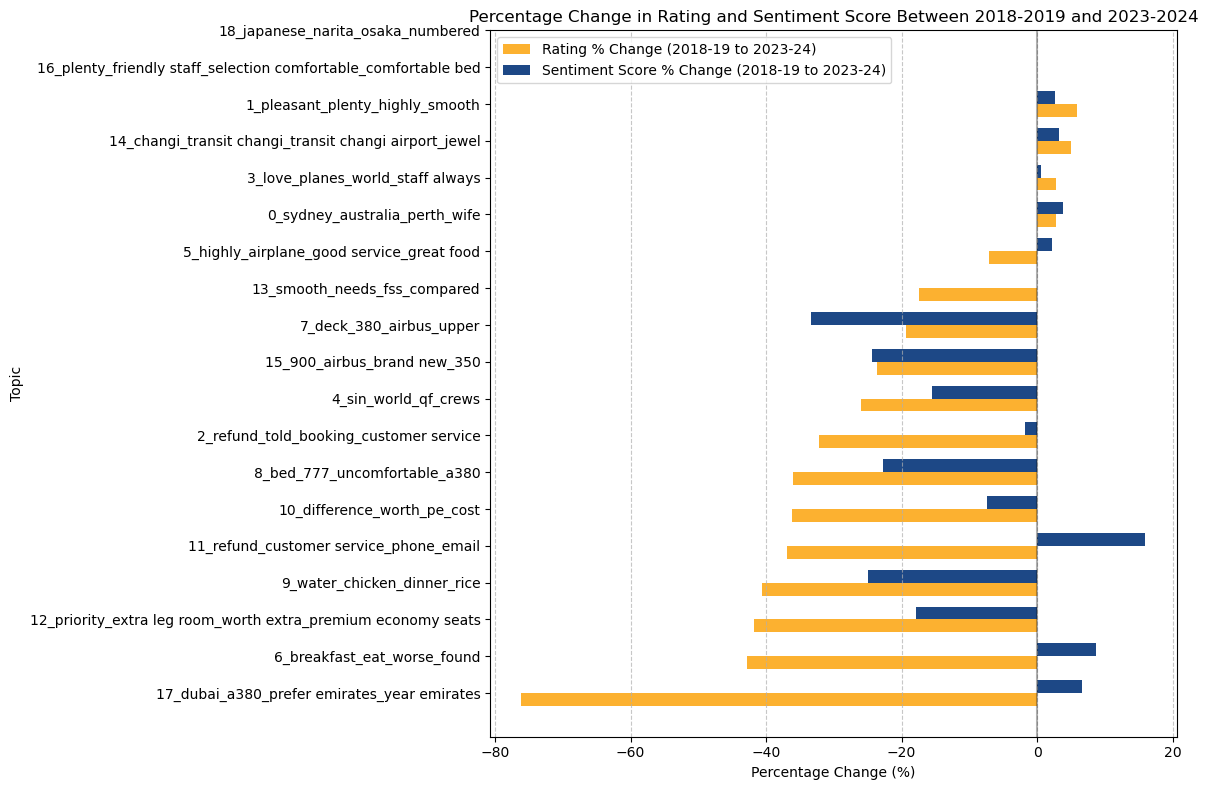

In [30]:
# Calculate percentage changes of mean rating and sentiment scores between 2018-2019 and 2023-2024
if 'year' in df.columns and 'text' in df.columns:
    # Define the periods
    period1_years = [2018, 2019]
    period2_years = [2023, 2024]
    
    # Create a copy of the topic_year_sentiment dataframe for analysis
    topic_analysis = topic_year_sentiment_filtered.copy()
    
    # Add period column (period1: 2018-2019 or period2: 2023-2024)
    topic_analysis['period'] = topic_analysis['year'].apply(
        lambda x: 'period1' if x in period1_years else 
                  'period2' if x in period2_years else 'other')
    
    # Filter to only include the two periods we're interested in
    topic_analysis = topic_analysis[topic_analysis['period'] != 'other']
    
    # Group by topic and period to get mean values
    period_stats = topic_analysis.groupby(['topic', 'period']).agg({
        'scaled_sentiment_score': 'mean',
        'rating': 'mean'
    }).reset_index()
    
    # Pivot the data to have period1 and period2 in separate columns
    pivot_sentiment = period_stats.pivot_table(
        index='topic', 
        columns='period', 
        values='scaled_sentiment_score'
    ).reset_index()
    
    pivot_rating = period_stats.pivot_table(
        index='topic', 
        columns='period', 
        values='rating'
    ).reset_index()
    
    # Calculate percentage changes
    results = pd.DataFrame({'topic': pivot_sentiment['topic']})
    
    # Handle cases where period1 or period2 might be missing
    for df_pivot, metric in [(pivot_sentiment, 'scaled_sentiment_score'), (pivot_rating, 'rating')]:
        if 'period1' in df_pivot.columns and 'period2' in df_pivot.columns:
            results[f'{metric}_period1'] = df_pivot['period1']
            results[f'{metric}_period2'] = df_pivot['period2']
            results[f'{metric}_pct_change'] = ((df_pivot['period2'] - df_pivot['period1']) / df_pivot['period1'] * 100).round(2)
        else:
            # Handle missing periods
            if 'period1' in df_pivot.columns:
                results[f'{metric}_period1'] = df_pivot['period1']
                results[f'{metric}_period2'] = np.nan
                results[f'{metric}_pct_change'] = np.nan
            elif 'period2' in df_pivot.columns:
                results[f'{metric}_period1'] = np.nan
                results[f'{metric}_period2'] = df_pivot['period2']
                results[f'{metric}_pct_change'] = np.nan
    
    # Get topic names for better readability
    topic_names_map = {}
    for topic in results['topic'].unique():
        if topic in topic_df_covid['topic'].values:
            # Extract the full topic_name without splitting
            topic_name = topic_df_covid.loc[topic_df_covid['topic'] == topic, 'topic_name'].values[0]
            topic_names_map[topic] = topic_name
        else:
            topic_names_map[topic] = f"Topic {topic}"
    
    results['topic_name'] = results['topic'].map(topic_names_map)
    
    # Sort by percentage change in rating
    results = results.sort_values('rating_pct_change', ascending=False)
    
    # Display the results
    print("\nPercentage Changes in Mean Rating and Sentiment Score Between 2018-2019 and 2023-2024:")
    display_cols = ['topic', 'topic_name', 
                    'rating_period1', 'rating_period2', 'rating_pct_change',
                    'scaled_sentiment_score_period1', 'scaled_sentiment_score_period2', 'scaled_sentiment_score_pct_change']
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(results[display_cols])
    
    # Create a visualization of the percentage changes
    plt.figure(figsize=(12, 8))
    
    # Sort by rating percentage change for the plot
    plot_data = results.sort_values('rating_pct_change', ascending=True).copy()
    
    # Create x positions for the bars
    x = np.arange(len(plot_data))
    width = 0.35
    
    # Create the bars
    plt.barh(x - width/2, plot_data['rating_pct_change'], width, label='Rating % Change (2018-19 to 2023-24)', color='#FCB130')
    plt.barh(x + width/2, plot_data['scaled_sentiment_score_pct_change'], width, label='Sentiment Score % Change (2018-19 to 2023-24)', color='#1D4886')
    
    # Add labels and title
    plt.xlabel('Percentage Change (%)')
    plt.ylabel('Topic')
    plt.title('Percentage Change in Rating and Sentiment Score Between 2018-2019 and 2023-2024')
    plt.yticks(x, [f"{name}" for topic, name in zip(plot_data['topic'], plot_data['topic_name'])])
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    plt.legend()
    
    # Add a vertical line at 0%
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nYear or text information is not available in the dataframe.")


### Interpreting Combined Topic Changes and Overall Customer Ratings

The percentage changes indicate that while individual sentiment shifts are relatively modest, most topics have experienced slight negative trends. This suggests that instead of a massive decline across all topics, it is the cumulative effect of several small, negative changes that drives customers to leave lower overall ratings.

### Rationale for Grouping Data by Year

I choose to analyze the entire dataset and group the data by year rather than slice it to investigate emerging topics. This approach ensures that the topics remain as comparable as possible over time. Since reviews can cover multiple distinct topics, mapping topics later on becomes challenging. Starting with a consistent topic pool from the beginning allows for a more accurate comparison across different time periods.


## Splitting Reviews into Sentences

To address the challenge of multiple distinct topics appearing within a single review, I split each review into individual sentences. This approach retains the original review’s rating for each sentence and assigns a sentiment score to each, allowing for a more accurate evaluation of sentiment for each topic. Additionally, this method produces more distinct topics with more consistent keywords compared to analyzing entire reviews.

In [31]:
# Split each review into sentences
def split_into_sentences(text):
    # basic sentence splitting
    sentences = re.split(r'\.(?:\s|$)', text)
    # Remove empty sentences and strip whitespace
    return [sentence.strip() for sentence in sentences if sentence.strip()]

# Create a list to store the data
sentence_data = []

# Process each review in the post-pandemic dataframe
for _, row in df.iterrows():
    text = row['text']
    rating = row['rating']
    year = row['year']
    month = row['month']
    
    # Split the text into sentences
    sentences = split_into_sentences(text)
    
    # Add each sentence to our data list
    for sentence in sentences:
        if sentence:  # Only add non-empty sentences
            sentence_data.append({
                'Sentence': sentence,
                'Rating': rating,
                'Year': year,
                'Month': month,
                'Text': text  # Original full text
            })

# Create the new dataframe
sentence_df_all = pd.DataFrame(sentence_data)

# Display information about the new dataframe
print(f"Original post-pandemic reviews: {df.shape[0]}")
print(f"Total sentences extracted: {sentence_df_all.shape[0]}")
print(f"Average sentences per review: {sentence_df_all.shape[0] / df.shape[0]:.2f}")

# Display the first few rows of the new dataframe
sentence_df_all.head()


Original post-pandemic reviews: 10000
Total sentences extracted: 60062
Average sentences per review: 6.01


,Sentence,Rating,Year,Month,Text
0,We used this airline to go from Singapore to London Heathrow,3,2024,3,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...
1,We had issues with tickets as they cancelled one of the tickets and trying to get it sorted cost a lot of money due to roaming charges for the len...,3,2024,3,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...
2,This was a very poor service,3,2024,3,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...
3,We got to the airport and had to check in at the desk due to this issue which meant online check in couldn't be done,3,2024,3,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...
4,"We were in premium economy which was spacious, two seats on either side of the plane and 3 seats in the middle",3,2024,3,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it...


In [32]:
random.seed(42)
np.random.seed(42)

topic_model_all_data_sentence = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=mmr_model,              
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=30           
)

# Fit the model on the entire dataset
topics_all_data, probs_all_data = topic_model_all_data_sentence.fit_transform(sentence_df_all['Sentence'])

# Reduce the number of topics
topic_model_all_data_sentence = topic_model_all_data_sentence.reduce_topics(sentence_df_all['Sentence'], nr_topics=21)

# Get the updated topics and probabilities after reduction
topics_all_data_sentence = topic_model_all_data_sentence.topics_
probs_all_data_sentence = topic_model_all_data_sentence.probabilities_

2025-04-14 11:58:04,941 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1877 [00:00<?, ?it/s]

2025-04-14 11:59:21,799 - BERTopic - Embedding - Completed ✓
2025-04-14 11:59:21,799 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-14 11:59:57,691 - BERTopic - Dimensionality - Completed ✓
2025-04-14 11:59:57,692 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-14 12:02:02,231 - BERTopic - Cluster - Completed ✓
2025-04-14 12:02:02,237 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 12:02:20,121 - BERTopic - Representation - Completed ✓
2025-04-14 12:02:20,685 - BERTopic - Topic reduction - Reducing number of topics
2025-04-14 12:02:20,721 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-14 12:02:22,676 - BERTopic - Representation - Completed ✓
2025-04-14 12:02:22,682 - BERTopic - Topic reduction - Reduced number of topics from 373 to 21


In [33]:
topic_model_all_data_sentence.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,40424,-1_food_seats_class_great,"[food, seats, class, great, business, always, entertainment, business class, hours, leg, check, friendly, air, airport, new, return, travel, cabin...","[Return flight to London, again in Premium Economy, My partner and i decided to travel to Australia on Singapore airlines,the checking in at Londo..."
1,0,4844,0_changi_airport_always_air,"[changi, airport, always, air, changi airport, great, business, class, world, first time, trip, sydney, staff, years, melbourne, would definitely,...","[Will continue to fly with said airlines even just in transit @ Changi airport to board another international flight, Changi airport is also one o..."
2,1,3307,1_food_meals_meal_drinks,"[food, meals, meal, drinks, served, water, good food, great, ice, breakfast, cream, entertainment, quality, book cook, tasty, food service, choice...","[Food is amazing, The food was amazing and also the presentation, Food is terrible]"
3,2,2862,2_clean_smooth_thank_helpful,"[clean, smooth, thank, helpful, check, always, boarding, attentive, attendants, pleasant, cake, efficient, birthday, cabin crew, staff friendly, p...","[the staff were all very friendly and helpful, And the staff were friendly, The flight was smooth and the planes are always kept clean]"
4,3,2438,3_seats_sleep_wheelchair_hours,"[seats, sleep, wheelchair, hours, old, cold, leg room, aircraft, night, delayed, economy, extra, due, row, bit, slept, wife, little, front, crying]","[My daughtercried for 3 hours!!! And didn't sleep at all, My wife on the wheelchair and she carry her electric wheelchair, Much more room for me, ..."
5,4,1197,4_customer service_phone_refund_paid,"[customer service, phone, refund, paid, email, rude, crew, check, response, still, called, tried, weeks, reply, received, calls, extra, cost, neve...","[Poor customer service, Customer service as it's worst, Customer service was awful]"
6,5,781,5_a380_new_777_aircraft,"[a380, new, 777, aircraft, a330, airbus, 900, 300, seats, new a350, boeing, boeing 777, old, 787, airbus a350, business class, configuration, bran...","[Long flight, with A380, New A380 configuration, It was the new A350]"
7,6,670,6_seats_seats comfortable_feet_space,"[seats, seats comfortable, feet, space, legroom, angle, economy, legs, comfortable seats, front, enough, flat bed, lie, wide, recline, uncomfortab...","[Seats comfortable, The leg room is more than enough for a 5 hours flight, Very very cramped and not much leg room]"
8,7,591,7_highly_keep_great way_keep good work,"[highly, keep, great way, keep good work, good work, would highly, great, work, 10, mr, definitely, difference, fss, anyone, overall good, star, s...","[Highly recommended, Highly recommended, Highly recommended]"
9,8,537,8_toilets_toilet_socks_hot towels,"[toilets, toilet, socks, hot towels, lavatories, towel, dirty, economy, blanket, kit, socks toothbrush, amenities, cleaned, toothbrushes, bathroom...","[We hadn't received a pack but the socks and amenities in the toilet are the same, One of the toilets was marked out of order in our aisle, and wh..."


In [34]:
topic_model_all_data_sentence.visualize_barchart(top_n_topics=len(topic_model_all_data_sentence.get_topic_info()))

In [35]:
# Print the "Name" column from the topic_model_all_data.get_topic_info() DataFrame
topic_info_sentence = topic_model_all_data_sentence.get_topic_info()
print("\nTopic Names:")
for name in topic_info_sentence['Name']:
    print(name)

# Print the representation of each topic
print("\nRepresentation:")
for topic_id in topic_model_all_data_sentence.get_topics():
    if topic_id != -1:  # Skip the outlier topic
        print(f"Topic {topic_id}: {topic_model_all_data_sentence.get_topic(topic_id)}")



Topic Names:
-1_food_seats_class_great
0_changi_airport_always_air
1_food_meals_meal_drinks
2_clean_smooth_thank_helpful
3_seats_sleep_wheelchair_hours
4_customer service_phone_refund_paid
5_a380_new_777_aircraft
6_seats_seats comfortable_feet_space
7_highly_keep_great way_keep good work
8_toilets_toilet_socks_hot towels
9_selection_system_shows_inflight entertainment
10_warned_anyone else_ever_bad
11_noise_cancelling_noise cancelling headphones_usb
12_premium_premium economy_economy premium_economy premium economy
13_first class_first_economy_seats
14_easy_check boarding_security_efficient
15_time time_arrived time_flights_time arrived time
16_complaints_complain_much_fault service
17_30kg_baggage_baggage allowance_carry
18_ife_controller_ife controller_control
19_masks_mask_wore_eye

Representation:
Topic 0: [('changi', 0.028425449099599202), ('airport', 0.024622406887146852), ('always', 0.024562585858515215), ('air', 0.021890860911357425), ('changi airport', 0.018786113293596217), 

I rename the topics to ensure a better interpretability and visualization.

In [36]:
# Define custom topic names that are more descriptive and meaningful
custom_topic_names = {
    "-1_food_seats_class_great": "General Experience & Comfort",
    "0_changi_airport_always_air": "Changi Airport Experience",
    "1_food_meals_meal_drinks": "Food & Beverage Service",
    "2_clean_smooth_thank_helpful": "Cleanliness & Staff Helpfulness",
    "3_seats_sleep_wheelchair_hours": "Seating Comfort & Accessibility",
    "4_customer service_phone_refund_paid": "Customer Service & Refunds",
    "5_a380_new_777_aircraft": "Aircraft Type & Condition",
    "6_seats_seats comfortable_feet_space": "Seat Comfort & Legroom",
    "7_highly_keep_great way_keep good work": "Positive Service Feedback",
    "8_toilets_toilet_socks_hot towels": "Amenities & Facilities",
    "9_selection_system_shows_inflight entertainment": "Entertainment Offering",
    "10_warned_anyone else_ever_bad": "Negative Experiences & Warnings",
    "11_noise_cancelling_noise cancelling headphones_usb": "Headphones & Connectivity",
    "12_premium_premium economy_economy premium_economy premium economy": "Premium Economy Experience",
    "13_first class_first_economy_seats": "Class Specific Experience",
    "14_easy_check boarding_security_efficient": "Check-in & Boarding Process",
    "15_time time_arrived time_flights_time arrived time": "Flight Timing & Punctuality",
    "16_complaints_complain_much_fault service": "Complaint Handling",
    "17_30kg_baggage_baggage allowance_carry": "Baggage Allowance & Policies",
    "18_ife_controller_ife controller_control": "In-Flight Entertainment Controls",
    "19_masks_mask_wore_eye": "COVID Safety Measures"
}

# Get the topic info dataframe
topic_info_sentence = topic_model_all_data_sentence.get_topic_info()

# Create a new column for custom names
topic_info_sentence['CustomName'] = topic_info_sentence['Name'].map(
    lambda name: custom_topic_names.get(name, name)
)

# Display the updated topic information with custom names
updated_topic_info_sentence = topic_info_sentence
updated_topic_info_sentence


,Topic,Count,Name,Representation,Representative_Docs,CustomName
0,-1,40424,-1_food_seats_class_great,"[food, seats, class, great, business, always, entertainment, business class, hours, leg, check, friendly, air, airport, new, return, travel, cabin...","[Return flight to London, again in Premium Economy, My partner and i decided to travel to Australia on Singapore airlines,the checking in at Londo...",General Experience & Comfort
1,0,4844,0_changi_airport_always_air,"[changi, airport, always, air, changi airport, great, business, class, world, first time, trip, sydney, staff, years, melbourne, would definitely,...","[Will continue to fly with said airlines even just in transit @ Changi airport to board another international flight, Changi airport is also one o...",Changi Airport Experience
2,1,3307,1_food_meals_meal_drinks,"[food, meals, meal, drinks, served, water, good food, great, ice, breakfast, cream, entertainment, quality, book cook, tasty, food service, choice...","[Food is amazing, The food was amazing and also the presentation, Food is terrible]",Food & Beverage Service
3,2,2862,2_clean_smooth_thank_helpful,"[clean, smooth, thank, helpful, check, always, boarding, attentive, attendants, pleasant, cake, efficient, birthday, cabin crew, staff friendly, p...","[the staff were all very friendly and helpful, And the staff were friendly, The flight was smooth and the planes are always kept clean]",Cleanliness & Staff Helpfulness
4,3,2438,3_seats_sleep_wheelchair_hours,"[seats, sleep, wheelchair, hours, old, cold, leg room, aircraft, night, delayed, economy, extra, due, row, bit, slept, wife, little, front, crying]","[My daughtercried for 3 hours!!! And didn't sleep at all, My wife on the wheelchair and she carry her electric wheelchair, Much more room for me, ...",Seating Comfort & Accessibility
5,4,1197,4_customer service_phone_refund_paid,"[customer service, phone, refund, paid, email, rude, crew, check, response, still, called, tried, weeks, reply, received, calls, extra, cost, neve...","[Poor customer service, Customer service as it's worst, Customer service was awful]",Customer Service & Refunds
6,5,781,5_a380_new_777_aircraft,"[a380, new, 777, aircraft, a330, airbus, 900, 300, seats, new a350, boeing, boeing 777, old, 787, airbus a350, business class, configuration, bran...","[Long flight, with A380, New A380 configuration, It was the new A350]",Aircraft Type & Condition
7,6,670,6_seats_seats comfortable_feet_space,"[seats, seats comfortable, feet, space, legroom, angle, economy, legs, comfortable seats, front, enough, flat bed, lie, wide, recline, uncomfortab...","[Seats comfortable, The leg room is more than enough for a 5 hours flight, Very very cramped and not much leg room]",Seat Comfort & Legroom
8,7,591,7_highly_keep_great way_keep good work,"[highly, keep, great way, keep good work, good work, would highly, great, work, 10, mr, definitely, difference, fss, anyone, overall good, star, s...","[Highly recommended, Highly recommended, Highly recommended]",Positive Service Feedback
9,8,537,8_toilets_toilet_socks_hot towels,"[toilets, toilet, socks, hot towels, lavatories, towel, dirty, economy, blanket, kit, socks toothbrush, amenities, cleaned, toothbrushes, bathroom...","[We hadn't received a pack but the socks and amenities in the toilet are the same, One of the toilets was marked out of order in our aisle, and wh...",Amenities & Facilities


In [37]:
# Get topic representations
topic_representations_sentence = {topic: topic_model_all_data_sentence.get_topic(topic) for topic in updated_topic_info_sentence['Topic'].unique() if topic != -1}
topic_representations_sentence[-1] = [("No specific topic", 1.0)]  # Add representation for outlier topic

# Create a mapping of topic IDs to their names
topic_names_sentence = {row['Topic']: row['CustomName'] for _, row in updated_topic_info_sentence.iterrows()}

# Create the DataFrame with topic information
topic_df_covid_sentence = pd.DataFrame({
    "topic": topics_all_data_sentence, 
    "document": sentence_df_all['Sentence'], 
    "year": sentence_df_all['Year'], 
    "month": sentence_df_all['Month'],
    "topic_name": [topic_names_sentence[topic] for topic in topics_all_data_sentence],
    "topic_keywords": [topic_representations_sentence[topic][:7] for topic in topics_all_data_sentence]  # Top 7 keywords per topic
})

In [38]:
topic_df_covid_sentence.head()

,topic,document,year,month,topic_name,topic_keywords
0,-1,We used this airline to go from Singapore to London Heathrow,2024,3,General Experience & Comfort,"[(No specific topic, 1.0)]"
1,-1,We had issues with tickets as they cancelled one of the tickets and trying to get it sorted cost a lot of money due to roaming charges for the len...,2024,3,General Experience & Comfort,"[(No specific topic, 1.0)]"
2,4,This was a very poor service,2024,3,Customer Service & Refunds,"[(customer service, 0.03659433287821138), (phone, 0.027950338544503222), (refund, 0.0278177640781897), (paid, 0.02208680414472953), (email, 0.0218..."
3,4,We got to the airport and had to check in at the desk due to this issue which meant online check in couldn't be done,2024,3,Customer Service & Refunds,"[(customer service, 0.03659433287821138), (phone, 0.027950338544503222), (refund, 0.0278177640781897), (paid, 0.02208680414472953), (email, 0.0218..."
4,3,"We were in premium economy which was spacious, two seats on either side of the plane and 3 seats in the middle",2024,3,Seating Comfort & Accessibility,"[(seats, 0.030276416716462157), (sleep, 0.0277028449829429), (wheelchair, 0.026477798555406957), (hours, 0.02607458526047959), (old, 0.02490671248..."


Topics 3 and 6 seem to cover similar keywords, therefore I merge them. Topics 7, 10, 16, 19 do not contain helpful information to further analyze and include in visualizations.

In [39]:
# Reassign topics
# 1. Assigning all observations of topic 3 to topic 6
# 2. Assigning topics 7, 10, 16 and 19 to -1

# Creating a copy of the dataframe to avoid modifying the original
topic_df_covid_sentence_modified = topic_df_covid_sentence.copy()

# Map topic 3 to topic 6
mask_topic_3 = topic_df_covid_sentence_modified['topic'] == 3
topic_df_covid_sentence_modified.loc[mask_topic_3, 'topic'] = 6
# Update the topic name for these reassigned rows
topic_6_name = topic_names_sentence[6]
topic_df_covid_sentence_modified.loc[mask_topic_3, 'topic_name'] = topic_6_name

# Update topic keywords one row at a time to avoid dimensionality issues
topic_6_keywords = topic_representations_sentence[6][:7]
for idx in topic_df_covid_sentence_modified[mask_topic_3].index:
    topic_df_covid_sentence_modified.at[idx, 'topic_keywords'] = topic_6_keywords

# Map topics 7, 10, 16 and 19 to -1
topics_to_reassign = [7, 10, 16, 19]
mask_topics_to_reassign = topic_df_covid_sentence_modified['topic'].isin(topics_to_reassign)
topic_df_covid_sentence_modified.loc[mask_topics_to_reassign, 'topic'] = -1
# Update the topic name for these reassigned rows
topic_minus_1_name = topic_names_sentence[-1]
topic_df_covid_sentence_modified.loc[mask_topics_to_reassign, 'topic_name'] = topic_minus_1_name

# Update topic keywords one row at a time for the reassigned topics
topic_minus_1_keywords = topic_representations_sentence[-1]
for idx in topic_df_covid_sentence_modified[mask_topics_to_reassign].index:
    topic_df_covid_sentence_modified.at[idx, 'topic_keywords'] = topic_minus_1_keywords

# Replace the original dataframe with the modified one
topic_df_covid_sentence = topic_df_covid_sentence_modified

# Display the first few rows to verify changes
print(f"Number of rows with topic 3: {sum(topic_df_covid_sentence['topic'] == 3)}")
print(f"Number of rows with topics 7, 10, 16, 19: {sum(topic_df_covid_sentence['topic'].isin([7, 10, 16, 19]))}")


Number of rows with topic 3: 0
Number of rows with topics 7, 10, 16, 19: 0


In [40]:
# Download VADER lexicon 
try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Add airline-specific terms to the VADER lexicon to improve accuracy
# These are terms commonly found in airline reviews with sentiment connotations
airline_specific_terms = {
    'delay': -2.0,
    'cancelled': -3.0,
    'comfortable': 2.0,
    'spacious': 2.0,
    'not spacious': -2.0,
    'cramped': -2.0,
    'attentive': 3.0,
    'rude': -3.0,
    'refund': -1.0,
    'legroom': 1.5,
    'entertainment': 1.0,
    # Additional airline-specific sentiment terms
    'frustration': -2.5,
    'disappointing': -2.0,
    'disappointed': -2.0,
    'terrible': -3.0,
    'awful': -3.0,
    'horrible': -3.0,
    'excellent': 3.0,
    'amazing': 3.0,
    'outstanding': 3.0,
    'poor': -2.0,
    'worst': -3.5,
    'best': 3.5,
    'unprofessional': -2.5,
    'inconvenient': -2.0,
    'hassle': -2.0,
    'nightmare': -3.0,
    'unacceptable': -2.5,
    'mediocre': -1.5,
    'subpar': -2.0,
    'wonderful': 3.0,
    'fantastic': 3.0
}

# Update the VADER lexicon with airline-specific terms
for term, score in airline_specific_terms.items():
    sid.lexicon[term] = score

# Function to classify sentiment based on both compound score and rating
def get_airline_sentiment(text, rating=None):
    if not isinstance(text, str):
        return 'neutral'  # Handle non-string inputs
    
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    # Adjust thresholds for airline reviews which tend to be more polarized
    if compound_score >= 0.1:
        return 'positive'
    elif compound_score <= -0.1:
        return 'negative'
    else:
        # If we have the rating, use it as a tiebreaker for neutral sentiment
        if rating is not None:
            if rating >= 4:
                return 'positive'
            elif rating <= 2:
                return 'negative'
        return 'neutral'

# Apply sentiment analysis to each review
topic_df_covid_sentence['sentiment_score'] = topic_df_covid_sentence['document'].apply(
    lambda x: sid.polarity_scores(x)['compound'] if isinstance(x, str) else 0
)



topic_df_covid_sentence['sentiment'] = topic_df_covid_sentence['document'].apply(get_airline_sentiment)    

# Display the first few rows with sentiment information
print("Singapore Airlines Reviews with Sentiment Analysis:")
print(topic_df_covid_sentence[['topic', 'topic_name', 'sentiment', 'sentiment_score']].head())

# Count of reviews by sentiment
sentiment_counts_sentence = topic_df_covid_sentence['sentiment'].value_counts()
print("\nSentiment distribution in Singapore Airlines reviews:")
print(sentiment_counts_sentence)




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mariuskiefer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Singapore Airlines Reviews with Sentiment Analysis:
   topic                    topic_name sentiment  sentiment_score
0     -1  General Experience & Comfort   neutral             0.00
1     -1  General Experience & Comfort  negative            -0.54
2      4    Customer Service & Refunds  negative            -0.51
3      4    Customer Service & Refunds   neutral             0.00
4      6        Seat Comfort & Legroom  positive             0.46

Sentiment distribution in Singapore Airlines reviews:
sentiment
positive    29976
neutral     18367
negative    11719
Name: count, dtype: int64


In [41]:
# Append rating from df to topic_df_covid
if 'Rating' in sentence_df_all  .columns:
    # Create a mapping from document to rating
    doc_to_rating = dict(zip(sentence_df_all['Sentence'], sentence_df_all['Rating']))
    
    # Add rating column to topic_df_covid
    topic_df_covid_sentence['rating'] = topic_df_covid_sentence['document'].map(doc_to_rating)
    
    print("\nReviews with sentiment and rating:")
    print(topic_df_covid_sentence[['topic', 'topic_name', 'sentiment', 'sentiment_score', 'rating']].head())
else:
    print("\nRating information is not available in the dataframe.")




Reviews with sentiment and rating:
   topic                    topic_name sentiment  sentiment_score  rating
0     -1  General Experience & Comfort   neutral             0.00       3
1     -1  General Experience & Comfort  negative            -0.54       3
2      4    Customer Service & Refunds  negative            -0.51       3
3      4    Customer Service & Refunds   neutral             0.00       3
4      6        Seat Comfort & Legroom  positive             0.46       3


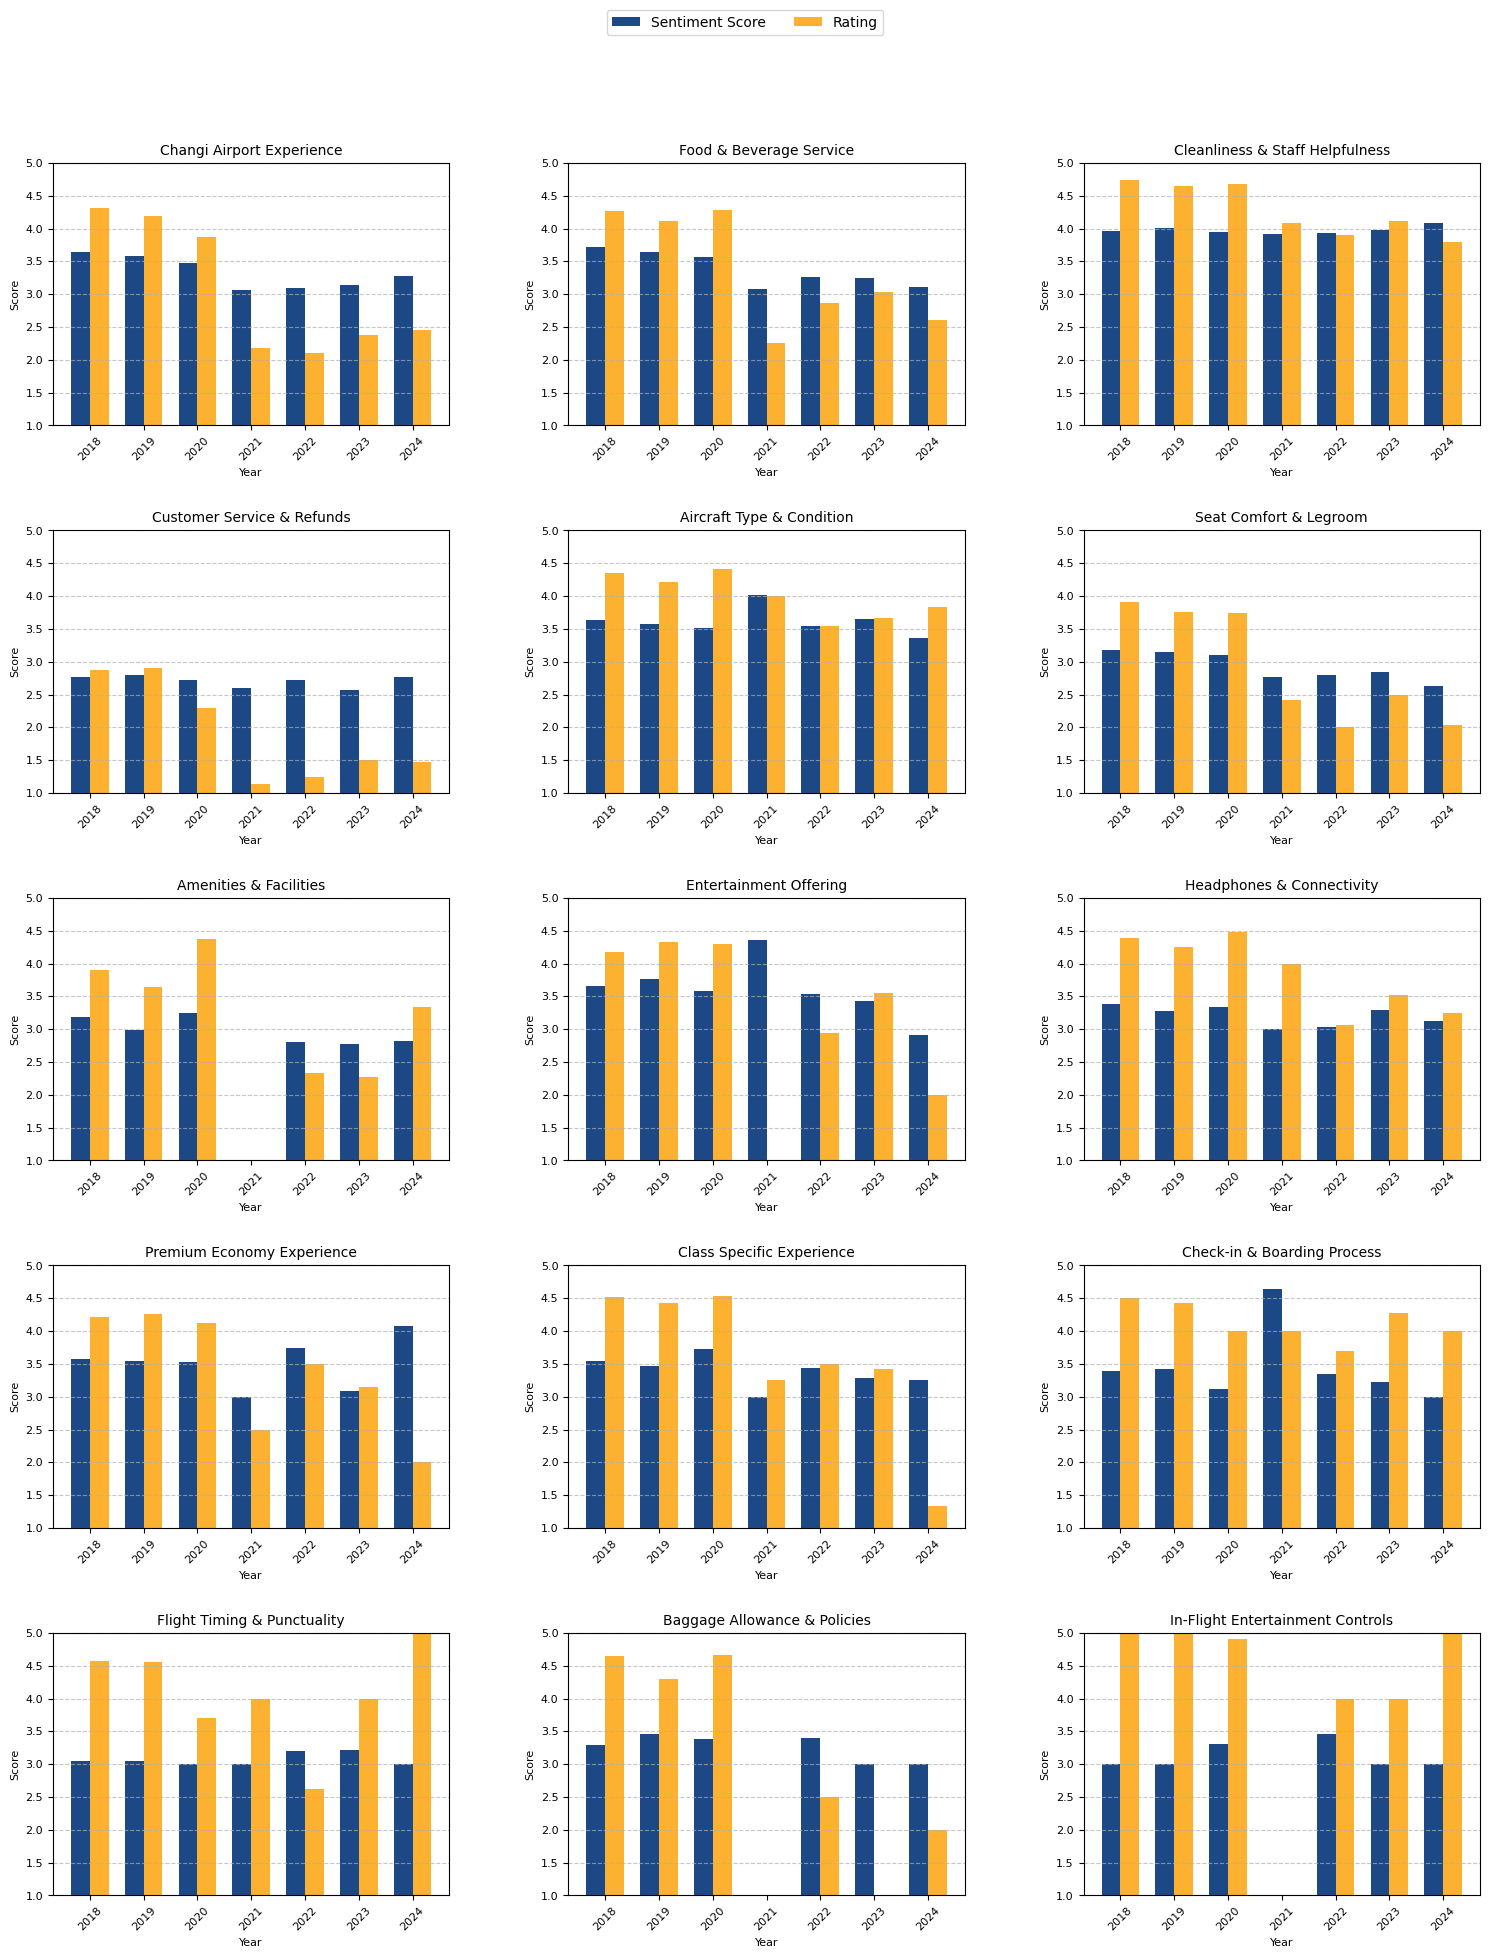


Summary of Mean Sentiment Score and Rating by Topic and Year:
     topic  year  scaled_sentiment_score  rating  \
7        0  2018                    3.64    4.32   
8        0  2019                    3.59    4.19   
9        0  2020                    3.48    3.87   
10       0  2021                    3.06    2.18   
11       0  2022                    3.10    2.11   
12       0  2023                    3.15    2.37   
13       0  2024                    3.28    2.45   
14       1  2018                    3.72    4.27   
15       1  2019                    3.64    4.11   
16       1  2020                    3.57    4.29   
17       1  2021                    3.08    2.25   
18       1  2022                    3.27    2.87   
19       1  2023                    3.25    3.04   
20       1  2024                    3.11    2.60   
21       2  2018                    3.96    4.73   
22       2  2019                    4.00    4.66   
23       2  2020                    3.94    4.68   
2

In [42]:
# Extract year from the original dataframe
if 'Year' in sentence_df_all.columns and 'Sentence' in sentence_df_all.columns:
    # Create a mapping from document to year
    doc_to_year = dict(zip(sentence_df_all['Sentence'], sentence_df_all['Year']))
    
    # Add year column to topic_df_covid
    topic_df_covid_sentence['year'] = topic_df_covid_sentence['document'].map(doc_to_year)
    
    # Scale sentiment score from [-1,1] to [1,5] to match rating scale
    topic_df_covid_sentence['scaled_sentiment_score'] = topic_df_covid_sentence['sentiment_score'].apply(
        lambda x: ((x + 1) / 2) * 4 + 1
    )
    
    # Group by topic and year to calculate mean sentiment score and rating
    topic_year_sentiment_sentence = topic_df_covid_sentence.groupby(['topic', 'year']).agg({
        'scaled_sentiment_score': 'mean',
        'rating': 'mean'
    }).reset_index()
    
    # Filter out the -1 topic (no specific topic)
    topic_year_sentiment_filtered_sentence = topic_year_sentiment_sentence[topic_year_sentiment_sentence['topic'] != -1]
    
    # Create a mapping from topic ID to topic name
    topic_name_map_sentence = dict(zip(topic_df_covid_sentence['topic'], topic_df_covid_sentence['topic_name']))
    
    # Add topic name to the aggregated dataframe
    topic_year_sentiment_filtered_sentence['topic_name'] = topic_year_sentiment_filtered_sentence['topic'].map(topic_name_map_sentence)
    
    # Get unique topics and years
    unique_topics_sentence = topic_year_sentiment_filtered_sentence['topic'].unique()
    years_sentence = sorted(topic_year_sentiment_filtered_sentence['year'].unique())
    
    # Create a more compact grid layout
    n_topics_sentence = len(unique_topics_sentence)
    n_cols_sentence = 3  # Number of columns in the grid
    n_rows_sentence = (n_topics_sentence + n_cols_sentence - 1) // n_cols_sentence  # Calculate number of rows needed
    
    fig, axes = plt.subplots(n_rows_sentence, n_cols_sentence, figsize=(15, 4*n_rows_sentence), squeeze=False)
    
    # Flatten the axes array for easier indexing
    axes_flat = axes.flatten()
    
    for i, topic in enumerate(unique_topics_sentence):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Filter data for this topic
            topic_data_sentence = topic_year_sentiment_filtered_sentence[topic_year_sentiment_filtered_sentence['topic'] == topic]
            topic_name_sentence = topic_data_sentence['topic_name'].iloc[0]
            
            # Create a DataFrame with all years (to handle missing years)
            all_years_df_sentence = pd.DataFrame({'year': years_sentence})
            topic_data_sentence = pd.merge(all_years_df_sentence, topic_data_sentence, on='year', how='left').fillna(0)
            topic_data_sentence = topic_data_sentence.sort_values('year')
            
            # Get x positions for bars
            x_pos = np.arange(len(years_sentence))
            bar_width = 0.35
            
            # Define colors for bars
            sentiment_color = '#1D4886'  # Blue
            rating_color = '#FCB130'     # Orange
            
            # Plot bars
            ax.bar(x_pos - bar_width/2, topic_data_sentence['scaled_sentiment_score'], bar_width, 
                   color=sentiment_color, label='Sentiment Score')
            ax.bar(x_pos + bar_width/2, topic_data_sentence['rating'], bar_width, 
                   color=rating_color, label='Rating')
            
            # Set title and labels
            ax.set_title(f'{topic_name_sentence}', fontsize=10)
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel('Score', fontsize=8)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(years_sentence, rotation=45, fontsize=8)
            ax.set_ylim(1, 5)  # Set y-axis limits
            ax.tick_params(axis='y', labelsize=8)
            ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Hide any unused subplots
    for j in range(i+1, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    # Add a single legend for the entire figure
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)
    plt.show()
    
    # Print summary statistics
    print("\nSummary of Mean Sentiment Score and Rating by Topic and Year:")
    print(topic_year_sentiment_filtered_sentence.sort_values(['topic', 'year']))
else:
    print("\nYear or Sentence information is not available in the dataframe.")


Similar to the previous approach, a slight decline in topic sentiment scores and average ratings is observed. However, some years lack sufficient data to draw meaningful conclusions. Analyzing reviews at the sentence level appears to provide a more robust and precise solution. 

Food, Entertainment, Seat Comfort, and Baggage Allowance demonstrate the most pronounced lasting negative trends.

To further analyze this I want to look at the perecentage changes of sentiment and rating averages (Pre-Covid vs. Post-Covid)



Percentage Changes in Mean Rating and Sentiment Score Between 2018-2019 and 2023-2024:


,topic,topic_name,rating_period1,rating_period2,rating_pct_change,scaled_sentiment_score_period1,scaled_sentiment_score_period2,scaled_sentiment_score_pct_change
12,15,Flight Timing & Punctuality,4.56,4.50,-1.42,3.05,3.11,2.07
11,14,Check-in & Boarding Process,4.47,4.14,-7.46,3.41,3.12,-8.66
14,18,In-Flight Entertainment Controls,5.00,4.50,-10.00,3.00,3.00,0.00
4,5,Aircraft Type & Condition,4.29,3.75,-12.50,3.61,3.51,-2.58
2,2,Cleanliness & Staff Helpfulness,4.69,3.96,-15.62,3.98,4.03,1.39
8,11,Headphones & Connectivity,4.32,3.38,-21.71,3.33,3.21,-3.71
6,8,Amenities & Facilities,3.77,2.80,-25.63,3.09,2.80,-9.36
1,1,Food & Beverage Service,4.19,2.82,-32.76,3.68,3.18,-13.62
7,9,Entertainment Offering,4.25,2.78,-34.68,3.72,3.17,-14.69
9,12,Premium Economy Experience,4.24,2.58,-39.22,3.56,3.59,0.84


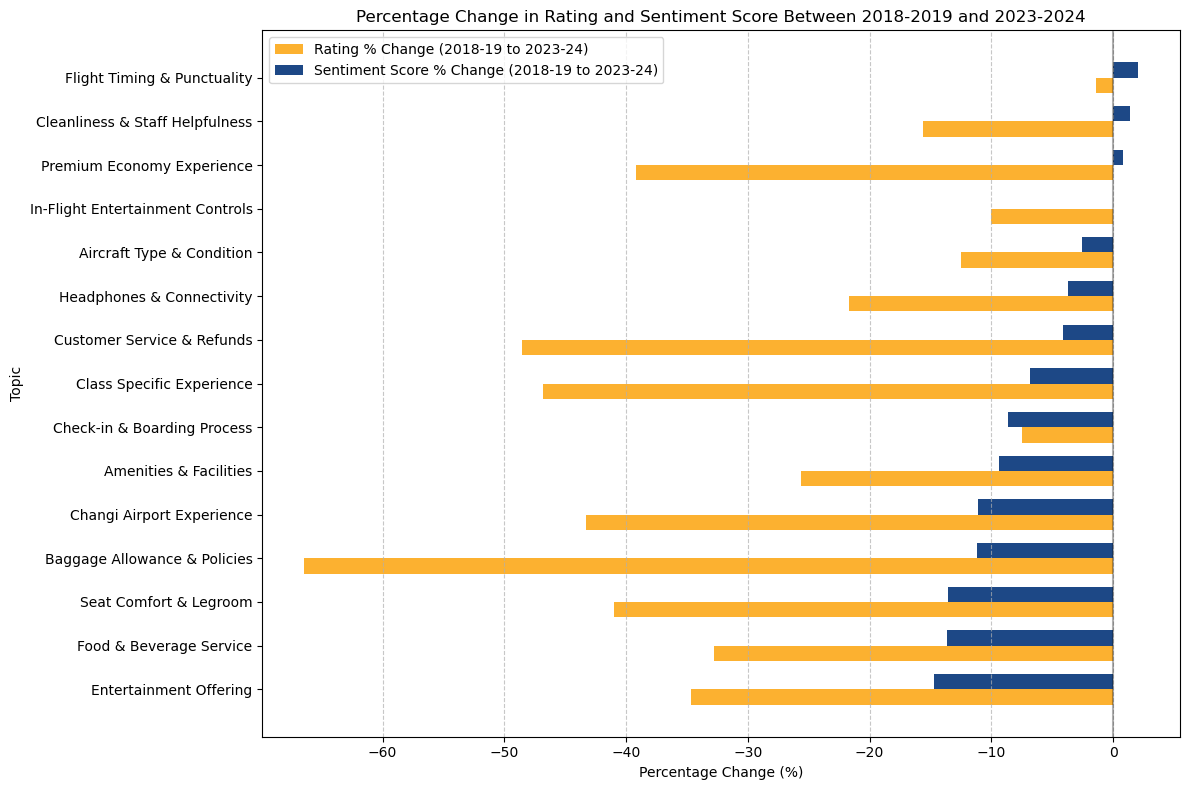

In [43]:
# Calculate percentage changes of mean rating and sentiment scores between 2018-2019 and 2023-2024
if 'Year' in sentence_df_all.columns and 'Sentence' in sentence_df_all.columns:
    # Define the periods
    period1_years = [2018, 2019]
    period2_years = [2023, 2024]
    
    # Create a copy of the topic_year_sentiment dataframe for analysis
    topic_analysis_sentence = topic_year_sentiment_filtered_sentence.copy()
    
    # Add period column (period1: 2018-2019 or period2: 2023-2024)
    topic_analysis_sentence['period'] = topic_analysis_sentence['year'].apply(
        lambda x: 'period1' if x in period1_years else 
                  'period2' if x in period2_years else 'other')
    
    # Filter to only include the two periods we're interested in
    topic_analysis_sentence = topic_analysis_sentence[topic_analysis_sentence['period'] != 'other']
    
    # Group by topic and period to get mean values
    period_stats_sentence = topic_analysis_sentence.groupby(['topic', 'period']).agg({
        'scaled_sentiment_score': 'mean',
        'rating': 'mean'
    }).reset_index()
    
    # Pivot the data to have period1 and period2 in separate columns
    pivot_sentiment_sentence = period_stats_sentence.pivot_table(
        index='topic', 
        columns='period', 
        values='scaled_sentiment_score'
    ).reset_index()
    
    pivot_rating_sentence = period_stats_sentence.pivot_table(
        index='topic', 
        columns='period', 
        values='rating'
    ).reset_index()
    
    # Calculate percentage changes
    results_sentence = pd.DataFrame({'topic': pivot_sentiment_sentence['topic']})
    
    # Handle cases where period1 or period2 might be missing
    for df_pivot_sentence, metric in [(pivot_sentiment_sentence, 'scaled_sentiment_score'), (pivot_rating_sentence, 'rating')]:
        if 'period1' in df_pivot_sentence.columns and 'period2' in df_pivot_sentence.columns:
            results_sentence[f'{metric}_period1'] = df_pivot_sentence['period1']
            results_sentence[f'{metric}_period2'] = df_pivot_sentence['period2']
            results_sentence[f'{metric}_pct_change'] = ((df_pivot_sentence['period2'] - df_pivot_sentence['period1']) / df_pivot_sentence['period1'] * 100).round(2)
        else:
            # Handle missing periods
            if 'period1' in df_pivot_sentence.columns:
                results_sentence[f'{metric}_period1'] = df_pivot_sentence['period1']
                results_sentence[f'{metric}_period2'] = np.nan
                results_sentence[f'{metric}_pct_change'] = np.nan
            elif 'period2' in df_pivot_sentence.columns:
                results_sentence[f'{metric}_period1'] = np.nan
                results_sentence[f'{metric}_period2'] = df_pivot_sentence['period2']
                results_sentence[f'{metric}_pct_change'] = np.nan
    
    # Get topic names for better readability
    topic_names_sentence = {}
    for topic in results_sentence['topic'].unique():
        if topic in topic_df_covid_sentence['topic'].values:
            # Extract the full topic_name without splitting
            topic_name = topic_df_covid_sentence.loc[topic_df_covid_sentence['topic'] == topic, 'topic_name'].values[0]
            topic_names_sentence[topic] = topic_name
        else:
            topic_names_sentence[topic] = f"Topic {topic}"
    
    results_sentence['topic_name'] = results_sentence['topic'].map(topic_names_sentence)
    
    # Sort by percentage change in rating
    results_sentence = results_sentence.sort_values('rating_pct_change', ascending=False)
    
    # Display the results
    print("\nPercentage Changes in Mean Rating and Sentiment Score Between 2018-2019 and 2023-2024:")
    display_cols = ['topic', 'topic_name', 
                    'rating_period1', 'rating_period2', 'rating_pct_change',
                    'scaled_sentiment_score_period1', 'scaled_sentiment_score_period2', 'scaled_sentiment_score_pct_change']
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(results_sentence[display_cols])
    
    # Create a visualization of the percentage changes
    plt.figure(figsize=(12, 8))
    
    # Sort by rating percentage change for the plot
    plot_data_sentence = results_sentence.sort_values('scaled_sentiment_score_pct_change', ascending=True).copy()
    
    # Create x positions for the bars
    x_sentence = np.arange(len(plot_data_sentence))
    width = 0.35
    
    # Create the bars
    plt.barh(x_sentence - width/2, plot_data_sentence['rating_pct_change'], width, label='Rating % Change (2018-19 to 2023-24)', color='#FCB130')
    plt.barh(x_sentence + width/2, plot_data_sentence['scaled_sentiment_score_pct_change'], width, label='Sentiment Score % Change (2018-19 to 2023-24)', color='#1D4886')
    
    # Add labels and title
    plt.xlabel('Percentage Change (%)')
    plt.ylabel('Topic')
    plt.title('Percentage Change in Rating and Sentiment Score Between 2018-2019 and 2023-2024')
    plt.yticks(x_sentence, [f"{name}" for topic, name in zip(plot_data_sentence['topic'], plot_data_sentence['topic_name'])])
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    plt.legend()
    
    # Add a vertical line at 0%
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nYear or Sentence information is not available in the dataframe.")


### Analysis and Recommendations

The percentage changes confirm that these topics remain negative, even though COVID should no longer have any direct influence. Notably, sentiment scores reveal only about a 10% decline in satisfaction, compared to the 38% drop indicated by ratings.

I recommend that the company specifically focus on the following areas:
- **Entertainment Offering**
- **Food & Beverage Service**
- **Seat Comfort & Legroom**
- **Baggage Allowance & Policies**
- **Ground Service Experience at Changi Airport**

It would be beneficial to compare current offerings and procedures to those from pre-COVID times to pinpoint which long-lasting changes are still leading to negative feedback.

I choose to focus on a limited number of topics for improvement to prioritize the areas with the most significant negative developments. Starting with these critical issues allows for targeted action and measurable impact. Attempting to address all topics at once could be overly costly and risk disrupting existing workflows. Once improvements are seen in the initial focus areas, the approach can be expanded to other topics.

Additionally, it is important to highlight that data for 2023 and 2024 is significantly less than in pre-COVID years. The yearly flucatuation in changes across some topics (Check-in & Boarding Process, Premium Economy Experience, Food & Beverage Service) suggests that the airline is not only facing specific challenges within individual topics but is also lacking efficient quality management. 

To better monitor future improvements, I suggest incentivizing customers to participate in post-flight surveys, for example, by awarding points through a rewards program, so that the company can effectively track ongoing changes with a meaningful amount of data.

### Summary of Recommendations

- **Target Key Areas:**  
  Focus on enhancing Entertainment Offering, Food & Beverage Service, Seat Comfort & Legroom, Baggage Allowance & Policies, and Ground Service Experience at Changi Airport.

- **Benchmark Against Pre-COVID Standards:**  
  Compare current offerings and procedures to those from the pre-COVID era to identify persistent areas of negative feedback.

- **Strengthen Quality Management:**  
  Improve overall quality management processes to address not only specific issues but also broader service challenges.

- **Increase Customer Feedback:**  
  Incentivize customers to participate in post-flight surveys, for example, by rewarding them with points, to continually monitor and guide improvements.

